In [1]:
!pip install --proxy http://zeynally.avp.ru:8888 torch
!pip install --proxy http://zeynally.avp.ru:8888 torchvision
!pip install --proxy http://zeynally.avp.ru:8888 albumentations

## Import

In [2]:
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

import albumentations as A
import cv2
import glob
import numpy as np
import random
import os
import copy
import torch
import torchvision
import torchvision.transforms as transforms

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

## Create Train and Test sets

In [3]:
raw_data_path = 'rawdata/dogs'
train_data_path = os.path.join(raw_data_path, 'train') 
test_data_path = os.path.join(raw_data_path, 'test')

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(np.concatenate(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('classes ', classes)

#2.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(np.concatenate(test_image_paths))

print("Train size: {}\nTest size: {}".format(len(train_image_paths), len(test_image_paths)))

train_image_path example:  rawdata/dogs/train/affenpinscher/n02110627_12391.jpg
classes  ['affenpinscher', 'afghanhound']
Train size: 287
Test size: 102


## Define Dataset Class

In [4]:


class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        self.idx_to_class = {i:j for i, j in enumerate(classes)}
        self.class_to_idx = {value:key for key,value in self.idx_to_class.items()}
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = image_filepath.split('/')[-2]
        label = self.class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

## Define Transforms

In [5]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Resize((64,64))])

In [6]:
train_dataset = LandmarkDataset(train_image_paths,transform)
test_dataset = LandmarkDataset(test_image_paths,transform)

## Create Loaders

In [7]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Visualize

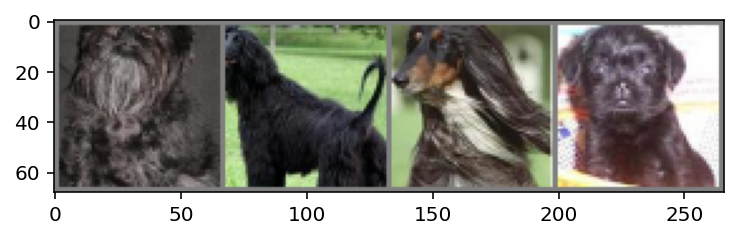

affenpinscher afghanhound afghanhound affenpinscher


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Create Neural Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 440)
        self.fc2 = nn.Linear(440, 168)
        self.fc3 = nn.Linear(168, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Train 

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


## Save results

In [11]:
import os
net_path = './models/dogs.pth'
os.makedirs(os.path.dirname(net_path), exist_ok=True)
torch.save(net.state_dict(), net_path)

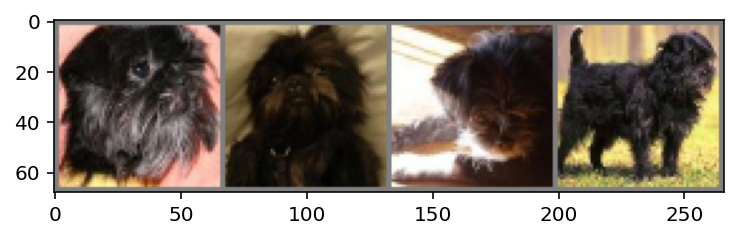

GroundTruth:  affenpinscher affenpinscher affenpinscher affenpinscher


In [12]:
dataiter = iter(testloader)


images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
net = Net()
net.load_state_dict(torch.load(net_path))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

Predicted:  afghanhound afghanhound afghanhound afghanhound


In [16]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 77 %


In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each classу 
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: affenpinscher is 0.0 %
Accuracy for class: afghanhound is 100.0 %
